# Team Members:
- Amirhossein Mobayen

## Topic:
AI Chess Master

# Objective:
Build a Vision AI which understands a position by looking at the board!

In [1]:
import os

# Basic packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

print(tf.config.list_physical_devices('GPU'))

2023-07-21 11:31:52.597458: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-21 11:31:52.598994: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 11:31:52.626910: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 11:31:52.627456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 11:31:53.159893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

[]


2023-07-21 11:31:53.705045: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Step 1: Dataset Preparation


In [2]:
# Download the dataset from Kaggle and extract the relevant files.
# URL: https://www.kaggle.com/koryakinp/chess-positions

# Define the input image size for the model
img_height, img_width = 224, 224
batch_size = 32

# Define the path to the dataset directory
dataset_dir = './dataset/'

# Step 2: Data Preprocessing

In [3]:
# Load the dataset without setting label_mode
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    seed=123,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training'
)

# Extract file names as labels
train_labels = []
for image_batch, label_batch in train_ds:
    label_batch = [str(label) for label in label_batch]  # Convert label batch to strings
    train_labels.extend([os.path.basename(file_path) for file_path in label_batch])

# Convert labels to NumPy array
train_labels = np.array(train_labels)


Found 10000 files belonging to 2 classes.
Using 8000 files for training.


2023-07-21 11:31:53.947191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8000]
	 [[{{node Placeholder/_4}}]]
2023-07-21 11:31:53.947406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8000]
	 [[{{node Placeholder/_4}}]]


In [4]:
# Split the train_ds dataset into training and validation subsets
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    seed=123,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    subset='validation'
)

# Extract file names as labels for val_ds
val_labels = []
for _, label_batch in val_ds:
    label_batch = [str(label.numpy()) for label in label_batch]  # Convert label batch to strings
    val_labels.extend(label_batch)

# Convert labels to NumPy array
val_labels = np.array(val_labels)

Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


2023-07-21 11:31:55.441054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-07-21 11:31:55.441198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


# Step 3: Model Selection and Architecture

In [5]:
num_classes = 13  # Number of classes (chess pieces + empty square)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 64)                25233472  
                                                                 
 dense_1 (Dense)             (None, 13)                845       
                                                                 
Total params: 25,234,637
Trainable params: 25,234,637
Non-trainable params: 0
____________________________________________

# Step 4: Model Training

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, batch_size=32, epochs=10, validation_data=val_ds)


Epoch 1/10
250/250 [==============================] - 82s 326ms/step - loss: 153.0442 - accuracy: 0.6791 - val_loss: 2.0197 - val_accuracy: 0.8270
Epoch 2/10
250/250 [==============================] - 78s 312ms/step - loss: 1.9583 - accuracy: 0.7404 - val_loss: 0.4716 - val_accuracy: 0.7940
Epoch 3/10
250/250 [==============================] - 81s 323ms/step - loss: 0.4761 - accuracy: 0.8223 - val_loss: 0.1650 - val_accuracy: 0.9505
Epoch 4/10
250/250 [==============================] - 80s 318ms/step - loss: 0.3561 - accuracy: 0.8547 - val_loss: 0.1617 - val_accuracy: 0.9550
Epoch 5/10
250/250 [==============================] - 82s 327ms/step - loss: 0.3062 - accuracy: 0.8819 - val_loss: 0.2309 - val_accuracy: 0.9105
Epoch 6/10
250/250 [==============================] - 81s 322ms/step - loss: 0.2967 - accuracy: 0.8866 - val_loss: 0.1960 - val_accuracy: 0.9345
Epoch 7/10
250/250 [==============================] - 82s 326ms/step - loss: 0.2769 - accuracy: 0.8966 - val_loss: 0.2254 - val_

# Step 5: Model Evaluation

In [7]:
# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(val_ds)

63/63 [==============================] - 4s 56ms/step - loss: 0.1672 - accuracy: 0.9520


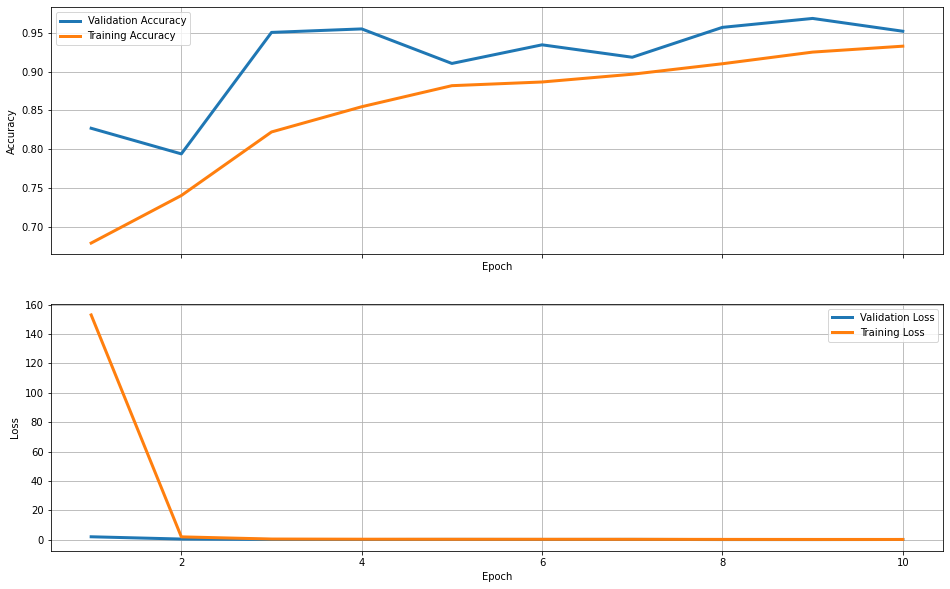

In [8]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns = ["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df) + 1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()


plot_results(history)

# Step 6: Model Deployment

In [9]:
# Save the trained model weights for future use
model.save('chessboard_model.h5')

# Load the saved model
loaded_model = tf.keras.models.load_model('chessboard_model.h5')

In [24]:
def convert_predictions_to_fen(predictions):
    fen_positions = []
    for prediction in predictions:
        fen = ""
        board = np.argmax(prediction, axis=-1)
        empty_counter = 0  # Initialize empty_counter for each prediction

        # Convert the board array into FEN format
        for idx, piece in enumerate(board.flatten()):
            if idx % 8 == 0 and idx != 0:
                if empty_counter > 0:
                    fen += str(empty_counter)
                    empty_counter = 0
                fen += "/"

            if piece == 0:
                empty_counter += 1
            else:
                if empty_counter > 0:
                    fen += str(empty_counter)
                    empty_counter = 0
                fen += chr(piece + 96)  # Convert piece value to ASCII character

        if empty_counter > 0:
            fen += str(empty_counter)

        # Append the FEN position to the list
        fen_positions.append(fen)

    return fen_positions


In [11]:
for images, labels in val_ds:
    predictions = model.predict(images)
    print("Predictions shape:", predictions.shape)
    print("Predictions:", predictions)
    print("Labels shape:", labels.shape)
    print("Labels:", labels)
    break  # Stop after the first batch for simplicity


1/1 [==============================] - 0s 88ms/step
Predictions shape: (32, 13)
Predictions: [[1.00045748e-01 8.99954259e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.20170780e-03 9.97798324e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.15557982e-35 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.25085556e-23]
 [3.17084929e-03 9.96829093e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.07420490e-34 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.07324715e-23]
 [1.32595166e-03 9.98674035e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.14644012e-24]
 [5.82313957e-03 9.94176865e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+

In [25]:
# Iterate over a few samples from the validation dataset
for images, labels in val_ds.take(5):
    # Make predictions on the images
    predictions = loaded_model.predict(images)

    # Convert predictions to FEN format
    predicted_positions = convert_predictions_to_fen(predictions)

    # Print the true label and predicted position for each sample
    for true_label, predicted_position in zip(labels, predicted_positions):
        print("True Label: ", true_label)
        print("Predicted Position: ", predicted_position)
        print("---")


1/1 [==============================] - 0s 68ms/step


2023-07-21 11:52:43.213809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-07-21 11:52:43.214425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  1
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  1
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label:  tf.Tensor(1, shape=(), dtype=int32)
Predicted Position:  a
---
True Label: 